In [20]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack.analysis import *
from icepack.splot import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}
mask = xr.open_dataset("~/sea_ice/data/masks/1x1/land2.nc")

In [21]:
method = 'mean'
daterange = (2007,2019)
daterange_clim = (2007,2019)

grid_path = "~/sea_ice/data/grids/grid_1x1.nc"
grid = xr.open_dataset(grid_path)

grid_path2 = "~/sea_ice/data/grids/nsidc_grid.nc"
grid2 = xr.open_dataset(grid_path2)

#### daily obs

In [22]:
sic_path = "~/sea_ice/data/obs/Had2CIS/sic/1x1/td_hadisst2.2_cis_great_cmc_monthly_cdo360x180_195901_202412_sicn.nc"
psl_path = "~/sea_ice/data/obs/ERA5/day/psl/era5_mean_sea_level_pressure_2016.nc"
grid_path = "~/sea_ice/data/grids/grid_1x1.nc"

# open data
sic_Had2CIS = format_time_coord(xr.open_dataset(sic_path),'1959-01','2024-12',freq='M').where(~np.isnan(mask.mask))
grid = xr.open_dataset(grid_path)

# calculate anomalies
sic_anom_Had2CIS = remove_mean(sic_Had2CIS,'sicn',ref_period=daterange)
sic_clim_Had2CIS = get_climatology(sic_Had2CIS,var='sicn',ref_period=daterange_clim)

# interpolated daily Had2CIS
sic_Had2CIS_daily = sic_Had2CIS.copy(deep=True)
sic_Had2CIS_daily['time'] = sic_Had2CIS_daily['time'] + np.timedelta64(14,'D')
sic_Had2CIS_daily = sic_Had2CIS_daily.where(sic_Had2CIS_daily['time.year'] >= 2015, drop=True)
sic_Had2CIS_daily = sic_Had2CIS_daily.resample(time='1D').interpolate('linear')
sie_Had2CIS_daily = get_iceextent(sic_Had2CIS_daily.where(sic_Had2CIS_daily['time.year']==2016,drop=True), grid, lat_bounds=(-90,-40), sic_label='sicn', lat_label='lat', lon_label='lon', ensemble=None)

/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


In [23]:
sic_path = "~/sea_ice/data/obs/OSI-SAF/sic/polstere/merged/ice_conc_sh_polstere-100_multi_201601-201612_1x1.nc"

# open data
sic_OSISAF = format_time_coord(xr.open_dataset(sic_path),'2016-01-01','2016-12-31',freq='D',leap_years=True)
grid = xr.open_dataset(grid_path)
sie_OSISAF = get_iceextent(sic_OSISAF, grid, lat_bounds=(-90,-40), sic_label='ice_conc', lat_label='lat', lon_label='lon', ensemble=None, sic_factor=1e-2)

/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


In [17]:
# open data
sic = xr.open_dataset("/home/rrp000/sea_ice/data/obs/NSIDC/sic/1x1/seaice_conc_daily_sh_cdr_seaice_conc_199101_202112_nrt_202201_filled_f_1x1.nc")
sic = format_time_coord(sic,'1991-01-01','2021-12-31',freq='D',leap_years=False)
sic = sic.rename_vars({'cdr_seaice_conc':'sicn'})
sic = sic.drop_vars(["lat_bnds","lon_bnds"])

# calculate SIE and anomalies
sie_NSIDC = get_iceextent(sic, grid2, lat_bounds=(-90,0), sic_label='sicn', lat_label='lat', lon_label='lon', ensemble=None, sic_factor=1)
# sie_anom_NSIDC = get_anomalies(sie_NSIDC,'SIE',ref_period=daterange)
# sie_clim_NSIDC = get_climatology(sie_NSIDC,var='SIE',ref_period=daterange_clim)

/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


#### w nudged + j initialized

In [24]:
sic_path_list = [f"~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnw2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc" for e in np.arange(1,10)]
sic_path_list.append("~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnw2-201601e10_dcppA-hindcast_s2015-r10i1p2f1_gn_20160101-20161231.nc")
psl_path_list = [f"~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds_20160101-20161231/psl/1x1/psl_day_CanESM5-c3bnw2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc" for e in np.arange(1,10)]
psl_path_list.append("~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds_20160101-20161231/psl/1x1/psl_day_CanESM5-c3bnw2-201601e10_dcppA-hindcast_s2015-r10i1p2f1_gn_20160101-20161231.nc")
grid_path = "~/sea_ice/data/grids/grid_1x1.nc"

# open data, each file corresponding to one ENSEMBLE
print("Opening data")
sic_CanESM5_wn2016_init_daily = []
psl_CanESM5_wn2016_init_daily = []
for i,path in enumerate(sic_path_list):
    sic = format_time_coord(xr.open_dataset(path),'2016-01-01','2016-12-31',freq='D',leap_years=False).drop_dims('bnds')
    psl = format_time_coord(xr.open_dataset(psl_path_list[i]),'2016-01-01','2016-12-31',freq='D',leap_years=False).drop_dims('bnds').where(~np.isnan(mask.mask))
    sic_CanESM5_wn2016_init_daily.append(sic)
    psl_CanESM5_wn2016_init_daily.append(psl)
grid = xr.open_dataset(grid_path)

# concatenate each ensemble
sic_CanESM5_wn2016_init_daily = xr.concat(sic_CanESM5_wn2016_init_daily,dim='ensemble')
psl_CanESM5_wn2016_init_daily = xr.concat(psl_CanESM5_wn2016_init_daily,dim='ensemble')
psl_CanESM5_wn2016_init_daily = psl_CanESM5_wn2016_init_daily.mean(dim='ensemble')
psl_CanESM5_wn2016_init_daily['psl'] *= 1e-2 

sie_CanESM5_wn2016_init_daily = get_iceextent(sic_CanESM5_wn2016_init_daily, grid, lat_bounds=(-90,-40), sic_label='siconc', lat_label='lat', lon_label='lon', ensemble='mean', sic_factor=1e-2)

Opening data


/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


In [25]:
sic_path_list = [f"~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds+temp_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnwt2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc" for e in np.arange(1,10)]
sic_path_list.append("~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds+temp_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnwt2-201601e10_dcppA-hindcast_s2015-r10i1p2f1_gn_20160101-20161231.nc")
psl_path_list = [f"~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds+temp_20160101-20161231/psl/1x1/psl_day_CanESM5-c3bnwt2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc" for e in np.arange(1,10)]
psl_path_list.append("~/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds+temp_20160101-20161231/psl/1x1/psl_day_CanESM5-c3bnwt2-201601e10_dcppA-hindcast_s2015-r10i1p2f1_gn_20160101-20161231.nc")
grid_path = "~/sea_ice/data/grids/grid_1x1.nc"

# open data, each file corresponding to one ENSEMBLE
print("Opening data")
sic_CanESM5_wtn2016_init_daily = []
psl_CanESM5_wtn2016_init_daily = []
for i,path in enumerate(sic_path_list):
    sic = format_time_coord(xr.open_dataset(path),'2016-01-01','2016-12-31',freq='D',leap_years=False).drop_dims('bnds')
    psl = format_time_coord(xr.open_dataset(psl_path_list[i]),'2016-01-01','2016-12-31',freq='D',leap_years=False).drop_dims('bnds').where(~np.isnan(mask.mask))
    sic_CanESM5_wtn2016_init_daily.append(sic)
    psl_CanESM5_wtn2016_init_daily.append(psl)
grid = xr.open_dataset(grid_path)

# concatenate each ensemble
sic_CanESM5_wtn2016_init_daily = xr.concat(sic_CanESM5_wtn2016_init_daily,dim='ensemble')
psl_CanESM5_wtn2016_init_daily = xr.concat(psl_CanESM5_wtn2016_init_daily,dim='ensemble')
psl_CanESM5_wtn2016_init_daily = psl_CanESM5_wtn2016_init_daily.mean(dim='ensemble')
psl_CanESM5_wtn2016_init_daily['psl'] *= 1e-2 

sie_CanESM5_wtn2016_init_daily = get_iceextent(sic_CanESM5_wtn2016_init_daily, grid, lat_bounds=(-90,-40), sic_label='siconc', lat_label='lat', lon_label='lon', ensemble='mean', sic_factor=1e-2)

Opening data


/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


# Plots

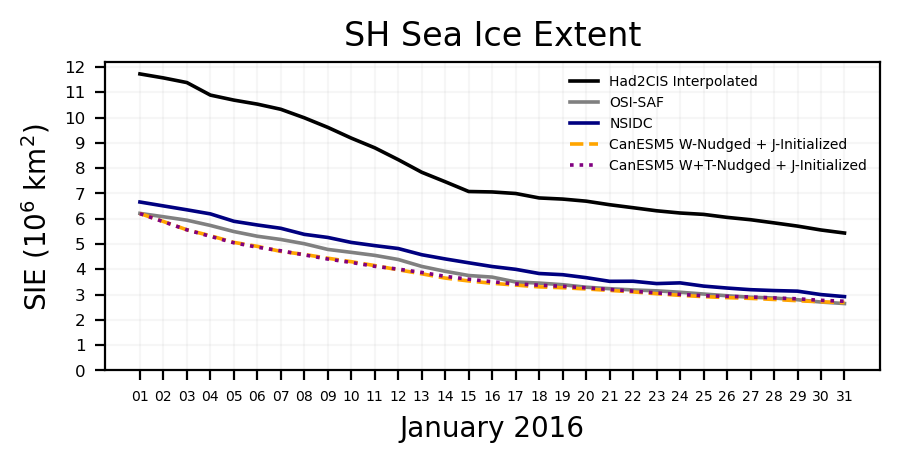

In [35]:
fix,ax=plt.subplots(1,1,figsize=(5,2),dpi=200)

# The data to be plotted, the years over which to plot, labels for legend, etc.
timeseries = [sie_Had2CIS_daily, sie_OSISAF, sie_NSIDC, sie_CanESM5_wn2016_init_daily, sie_CanESM5_wtn2016_init_daily]
colors = ['black','grey','navy','orange','purple']
linestyles = ['-','-','-','--',':']
labels = ['Had2CIS (Interpolated)','OSI-SAF','NSIDC','CanESM5 W-Nudged + J-Initialized','CanESM5 W+T-Nudged + J-Initialized']

# Plot the data
for i,data in enumerate(timeseries):
    data.where((data['time.year']==2016) & (data['time.month']==1),drop=True)['SIE'].plot.line(ax=ax,color=colors[i],linestyle=linestyles[i],linewidth=1.3)

# Other details of the plots
xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,31+1,1))
ax.set_xticks(np.arange(np.datetime64("2016-01-01"),np.datetime64("2016-01-31")+np.timedelta64(1,"D"),np.timedelta64(1,"D")))
ax.set_xticklabels(xlabels,size=5)
ax.set_xlabel("January 2016")
ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(np.arange(0,13),size=6)
ax.set_ylabel(r"SIE ($10^6\ \mathrm{km}^2$)")
ax.set_title("SH Sea Ice Extent")
ax.grid(alpha=0.1)
ax.legend(labels,fontsize=5,frameon=False)
plt.show()

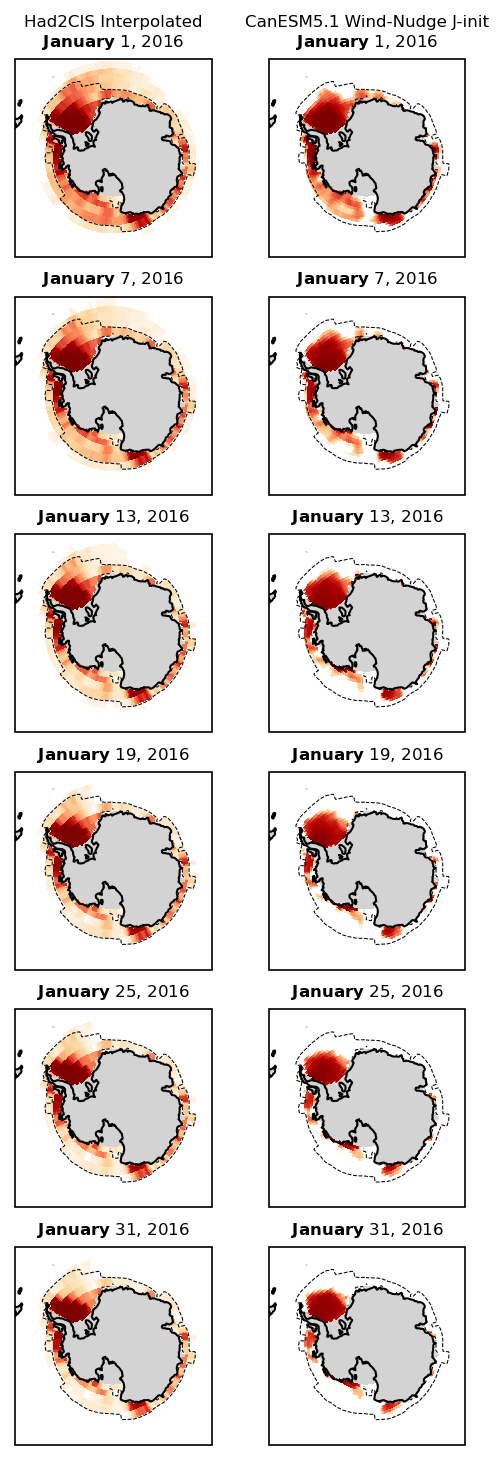

In [27]:
ncols=2
nrows=6 # i.e., number of days
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')]]
names = ["Had2CIS (Interpolated)","CanESM5.1 Wind-Nudge J-init"]
for i in np.arange(ncols): # dataset
    data = datasets[i]
    for j in np.arange(nrows): # days 
        d = 6*j+1
        set_extent(ax[j][i],domain=[-180,180,-90,-55])
        ax[j][i].coastlines()
        add_sic(ax[j][i], data[0], anom=False, month=1, year=2016, day=d)
        add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=1)
        if j == 0:
            ax[j][i].set_title(f"{names[i]}\n{monthdict[1]} {d}, 2016", size=8)
        else:
            ax[j][i].set_title(f"{monthdict[1]} {d}, 2016", size=8)

#plt.tight_layout()
plt.show()

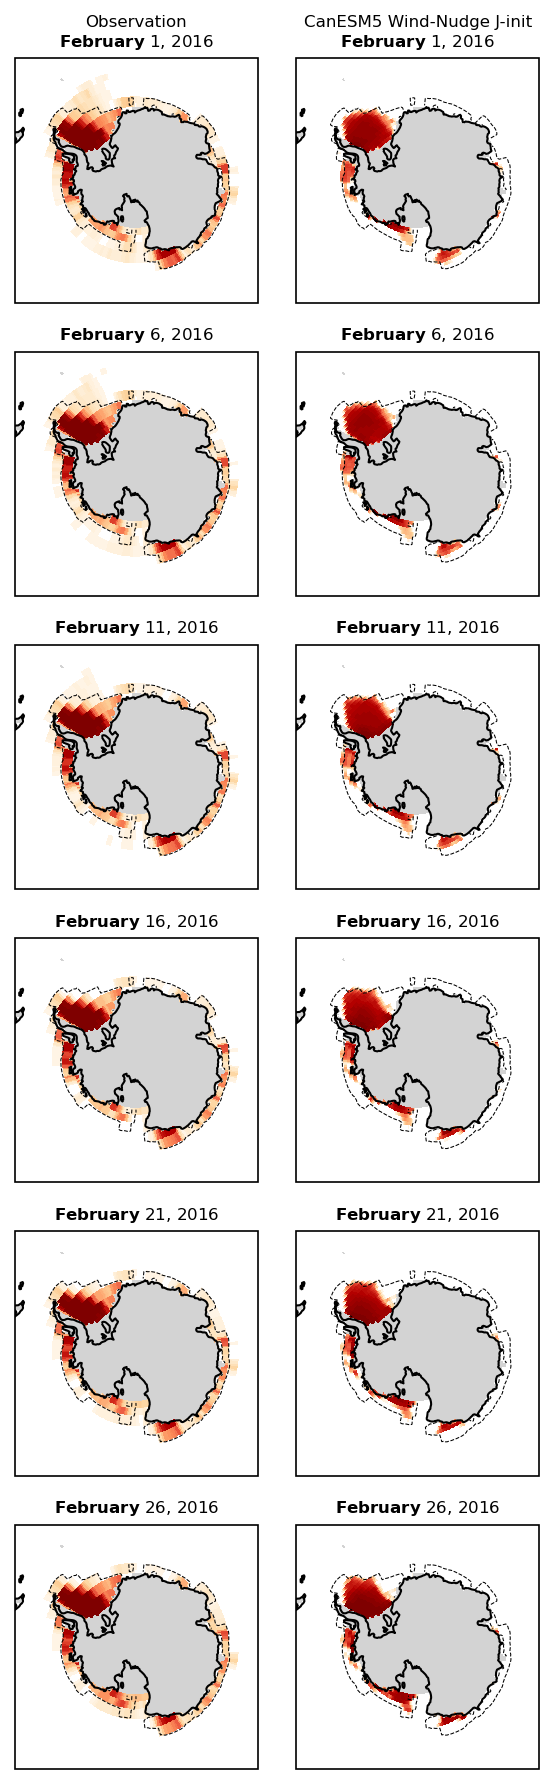

In [28]:
ncols=2
nrows=6 # i.e., number of days
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')]]
names = ["Observation","CanESM5 Wind-Nudge J-init"]
for i in np.arange(ncols): # dataset
    data = datasets[i]
    for j in np.arange(nrows): # days 
        d = 5*j+1
        set_extent(ax[j][i],domain=[-180,180,-90,-55])
        ax[j][i].coastlines()
        #add_psl(ax[j][i], data[1], month=2, year=2016, day=d)
        add_sic(ax[j][i], data[0], anom=False, month=2, year=2016, day=d)
        add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=2)
        if j == 0:
            ax[j][i].set_title(f"{names[i]}\n{monthdict[2]} {d}, 2016", size=8)
        else:
            ax[j][i].set_title(f"{monthdict[2]} {d}, 2016", size=8)

plt.tight_layout()
plt.show()

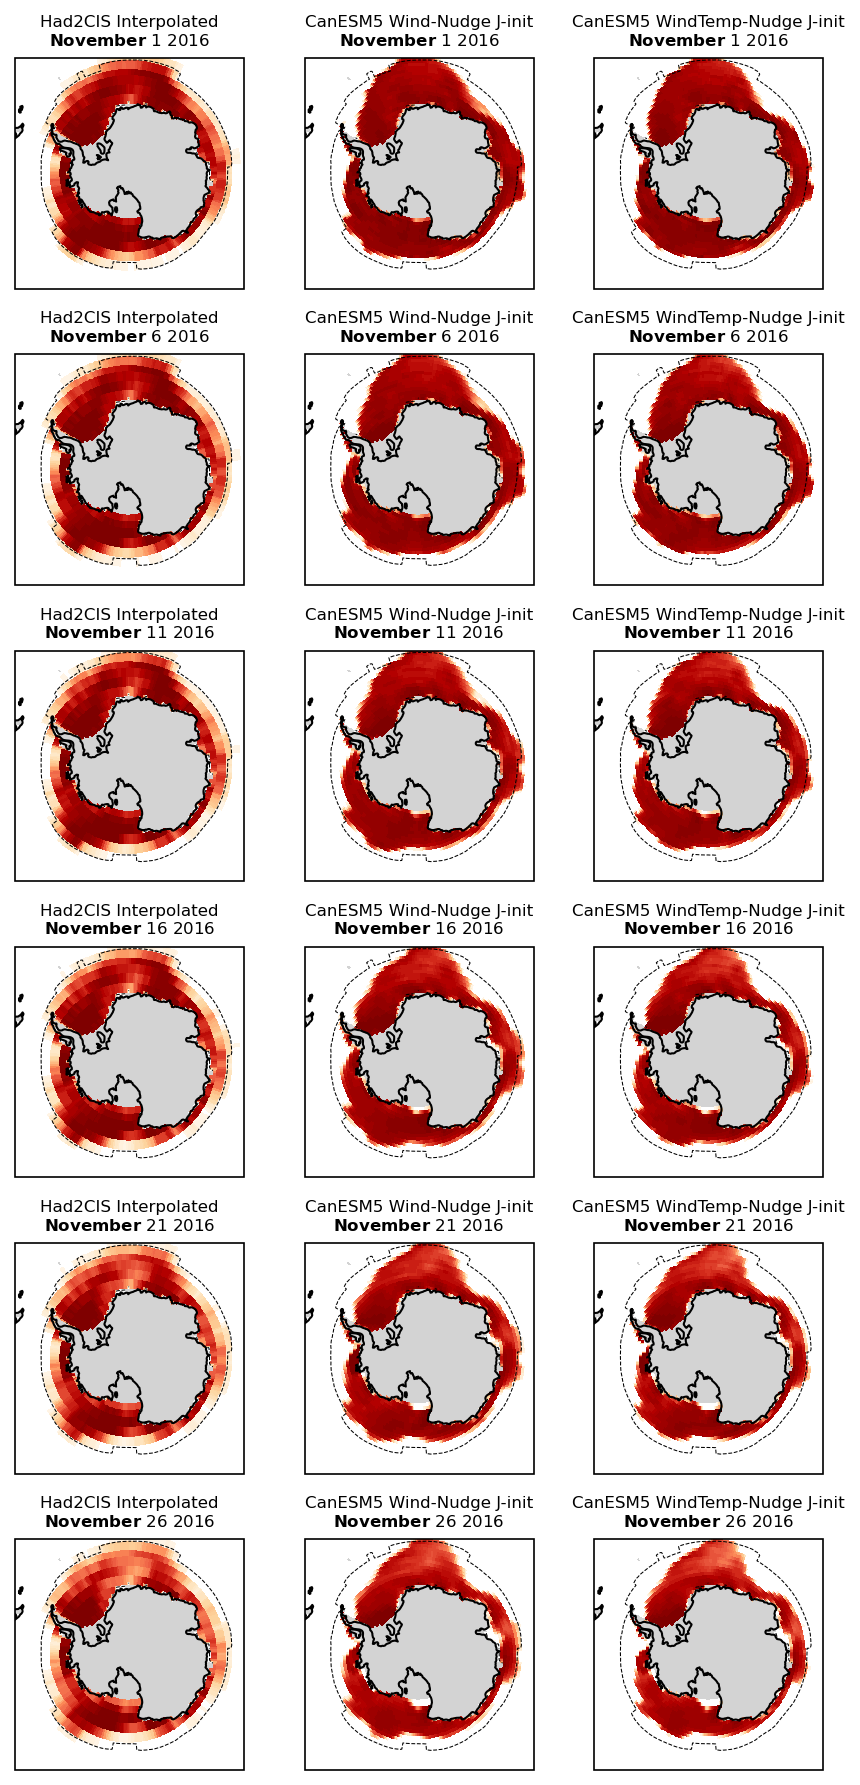

In [29]:
ncols=3
nrows=6 # i.e., number of days
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(6,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')],[sic_CanESM5_wtn2016_init_daily.mean(dim='ensemble')]]
names = ["Had2CIS Interpolated","CanESM5 Wind-Nudge J-init","CanESM5 WindTemp-Nudge J-init"]
for i in np.arange(ncols): # dataset
    data = datasets[i]
    for j in np.arange(nrows): # days 
        d = 5*j+1
        set_extent(ax[j][i],domain=[-180,180,-90,-55])
        ax[j][i].coastlines()
        #add_psl(ax[j][i], data[1], month=11, year=2016, day=d)
        add_sic(ax[j][i], data[0], anom=False, month=11, year=2016, day=d)
        add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=11)
        ax[j][i].set_title(f"{names[i]}\n{monthdict[11]} {d} 2016", size=8)

plt.tight_layout()
plt.show()